In [1]:
# cd("/home/xinhou/radPV/")
include("helper.jl")

agreeDots (generic function with 1 method)

In [2]:
lon = ncread(fnGr, "lon") 
lat = ncread(fnGr, "lat");

areaLat = area[1,:];

In [3]:
function mDays(s, m)
    m in [14,15,19,28] ?  days = 7160 :
    m in [3,4,5,6,12,13,16,17,20,26,27] ? days = 7300 : 
    s == 1 ? days = 7305 : days = 7304
    return days
end

mDays (generic function with 1 method)

In [4]:
function corr1grid(lon1, lat1, pv, areaLat) # correlate by one grid
    @views pv1 = pv[lon1,lat1,:] * (1/areaLat[lat1]) # normalize
    
    corr = zeros(16,16)
    for lat in 1:16
        for lon in 1:16
            @views pv2 = pv[lon,lat,:] * (1/areaLat[lat])
            corr[lon,lat] = cor(pv1, pv2)
        end
    end
    return corr
end

corr1grid (generic function with 1 method)

In [5]:
function corrAllGrid(pv) # correlate across all grids
    corrAll = zeros(16,16,16*16)
    g = 1 
    for lat in 16:(-1):1
        for lon in 1:16
            corrAll[:,:,g] = corr1grid(lon, lat, pv, areaLat)
            g += 1
        end
    end
    return corrAll # avg all grid 
end

corrAllGrid (generic function with 1 method)

In [6]:
function corrAllMdl(s, pathPv) # correlate by all models
    pathPv = joinpath(myPath, "pv", ssps[s], "day/EU/tilt_lat/regr")
    rmcp(pathPv)

    corrAllGridAllMdl = zeros(16,16,256,28)
    for m in 1:28
        println(m)
        fnam = joinpath(pathPv, readdir(pathPv)[m])
        pv = zeros(16,16,mDays(s, m)) # size (16,16,7300 or 7305 or 7160)
        ncread!(fnam, "pv", pv) 
        corrAllGridAllMdl[:,:,:,m] = corrAllGrid(pv) 
    end
    return corrAllGridAllMdl 
end

corrAllMdl (generic function with 1 method)

In [7]:
function corDif(corr, corH, op) # option 1: absolute; op 2: relative
    len = size(corr,3)
    corDiff = zeros(16,16,len) #256,len)
    for m in 1:len
        op == 1 ?
            (corDiff[:,:,m] = corr[:,:,m] - corH[:,:,m]) :
            (corDiff[:,:,m] = (corr[:,:,m] - corH[:,:,m]) ./ corH[:,:,m])
    end
    return corDiff
end

corDif (generic function with 1 method)

In [8]:
@time corH = corrAllMdl(1, pathPv)
cor1 = corrAllMdl(2, pathPv)
cor5 = corrAllMdl(5, pathPv);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
 82.424228 seconds (7.07 M allocations: 100.759 GiB, 5.87% gc time)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [9]:
corhMn, cor1Mn, cor5Mn = avg.([corH, cor1, cor5]);

In [10]:
cor1dif = corDif(cor1Mn, corhMn, 1)
cor5dif = corDif(cor5Mn, corhMn, 1);

16×16×28 Array{Float64,3}:
[:, :, 1] =
  0.0271224    0.0378754  0.0396618  …  0.0268276  0.045449   0.0489973
  0.0221058    0.0270978  0.0345641     0.0240293  0.0385042  0.0494717
  0.0224592    0.0124931  0.0274794     0.0172061  0.0285524  0.0476537
  0.00582483   0.0291545  0.0291249     0.0206568  0.0239625  0.0394322
 -0.012975     0.0200216  0.0476528     0.019651   0.0212916  0.03065
 -0.0146236    0.0203214  0.0445441  …  0.0228713  0.0223361  0.0271549
 -0.0146488    0.0209839  0.0465022     0.0272693  0.0222102  0.022349
 -0.000144715  0.0229938  0.0416131     0.0285174  0.0258757  0.019162
  0.023877     0.0315759  0.0404351     0.0269663  0.0288173  0.0235152
  0.0395591    0.0262112  0.0317399     0.0273824  0.0308738  0.0277044
  0.0351868    0.0259686  0.0252419  …  0.0412116  0.0321111  0.0268626
  0.0388296    0.0298536  0.0296        0.0715536  0.0352003  0.0261035
  0.0377563    0.0270008  0.0271625     0.0823664  0.0324672  0.0260586
  0.0301588    0.0207423  0.0

In [11]:
corDifs = avg.([cor1dif, cor5dif])
corAgr = agreeDots.([cor1dif, cor5dif]);

In [13]:
tlts = ["ssp1", "ssp5"];

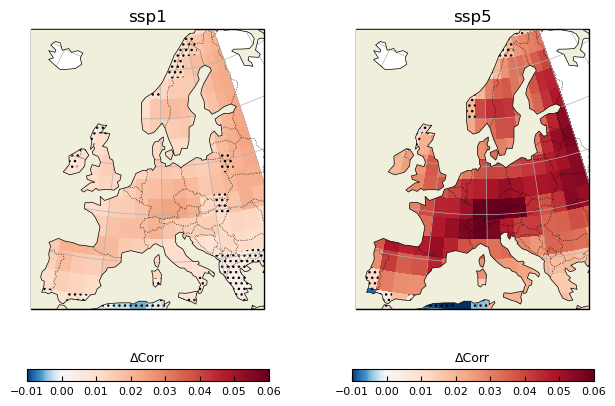

In [14]:
fig = plt.figure(figsize=(7,4.5))
for i in 1:2
    ax = plt.subplot(1,2,i, projection=proj3)
    title(tlts[i])
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    wrap_data, wrap_lon = cput.add_cyclic_point(corDifs[i]', coord=lon, axis=1)
    
    vmin, vmax = -0.01, 0.06
    norm = clrs.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    p = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="RdBu_r", norm=norm)
    ax.pcolor(lon, lat, corAgr[i], transform=proj1, alpha=0., hatch="...") 
    
    cbar = plt.colorbar(p, shrink=0.7, orientation="horizontal") 
    cbar.ax.set_title("ΔCorr", size=9)
    cbar.ax.tick_params(direction="in", labelsize=8)
end
plt.tight_layout()

### Indiv. models

In [16]:
mdls = [split(readdir(pathPv)[m], "_")[6] for m in 1:28];

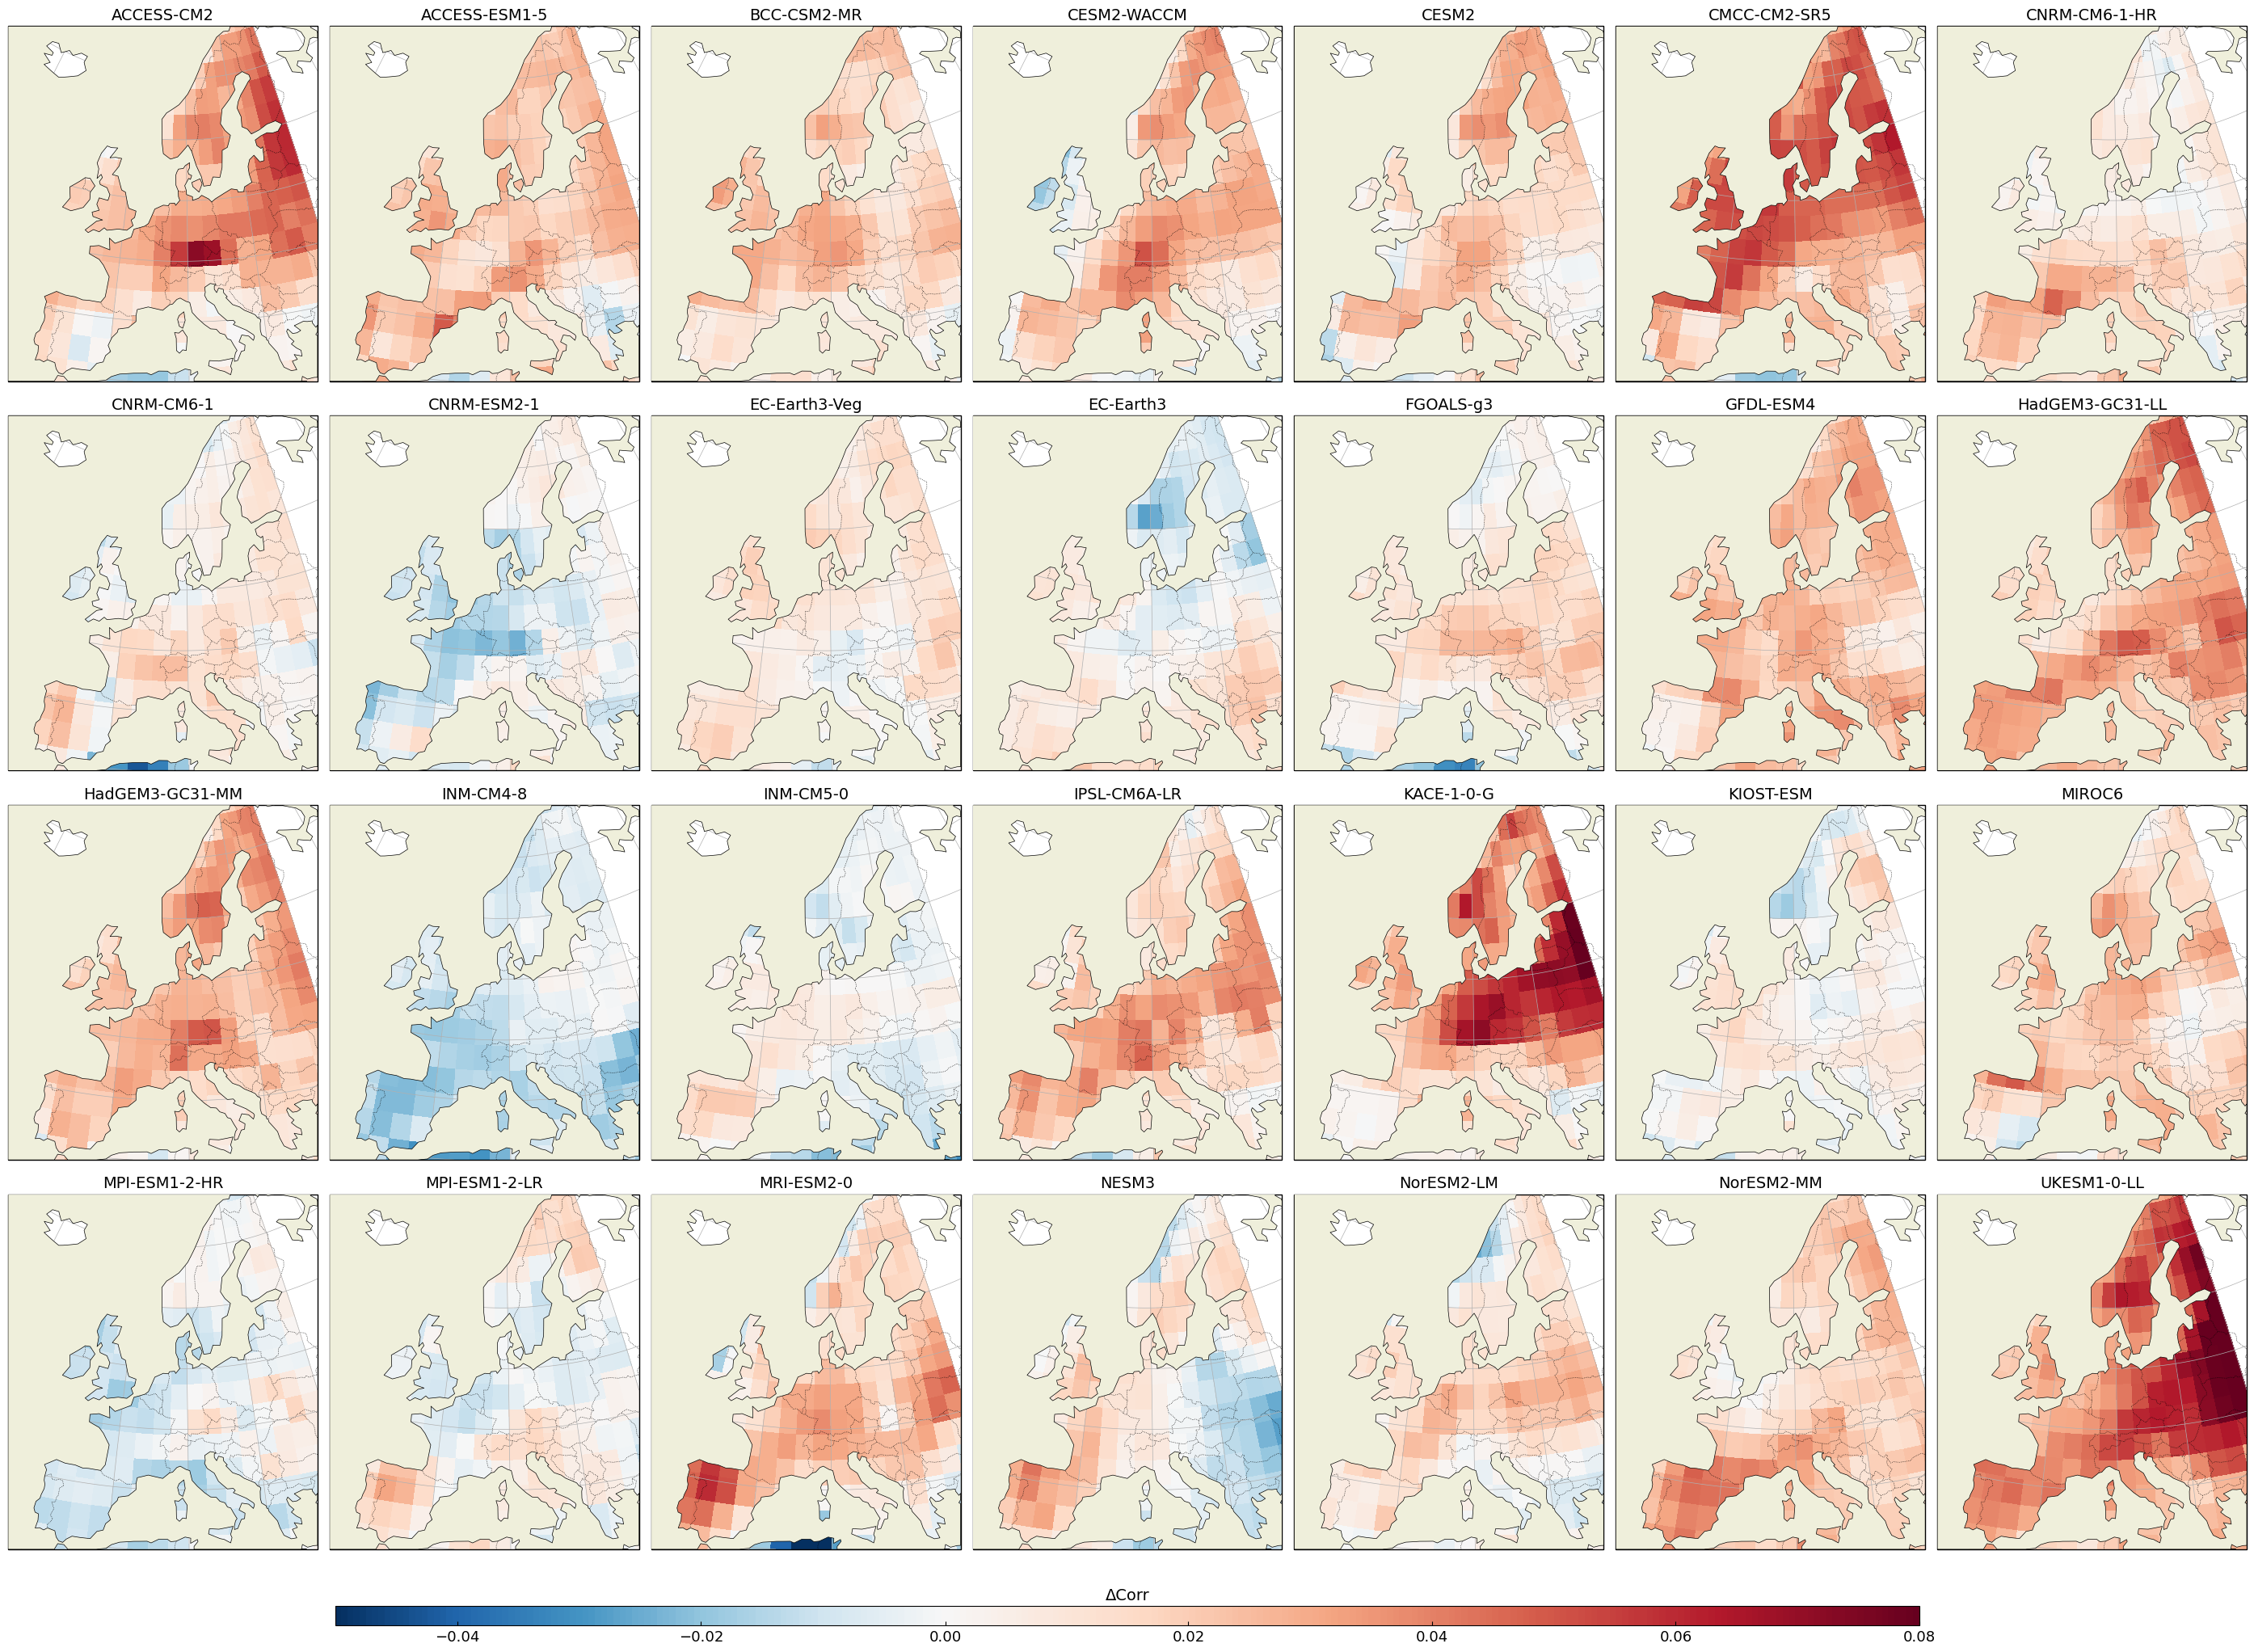

In [17]:
fig = plt.figure(figsize=(28,24)) 
for m in 1:28
    ax = plt.subplot(4,7, m, projection=proj3)
    ax.set_title(mdls[m], size=14)
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    
    wrap_data, wrap_lon = cput.add_cyclic_point(cor1dif[:,:,m]', coord=lon, axis=1)
    vmin, vmax = -0.05, 0.08
    norm = clrs.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    global md1 = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="RdBu_r", norm=norm)
end
plt.tight_layout()
fig.subplots_adjust(bottom=0.17)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.01])
fig.colorbar(md1, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_title("ΔCorr", size=14)
cbar_ax.tick_params(direction="in", labelsize=13)

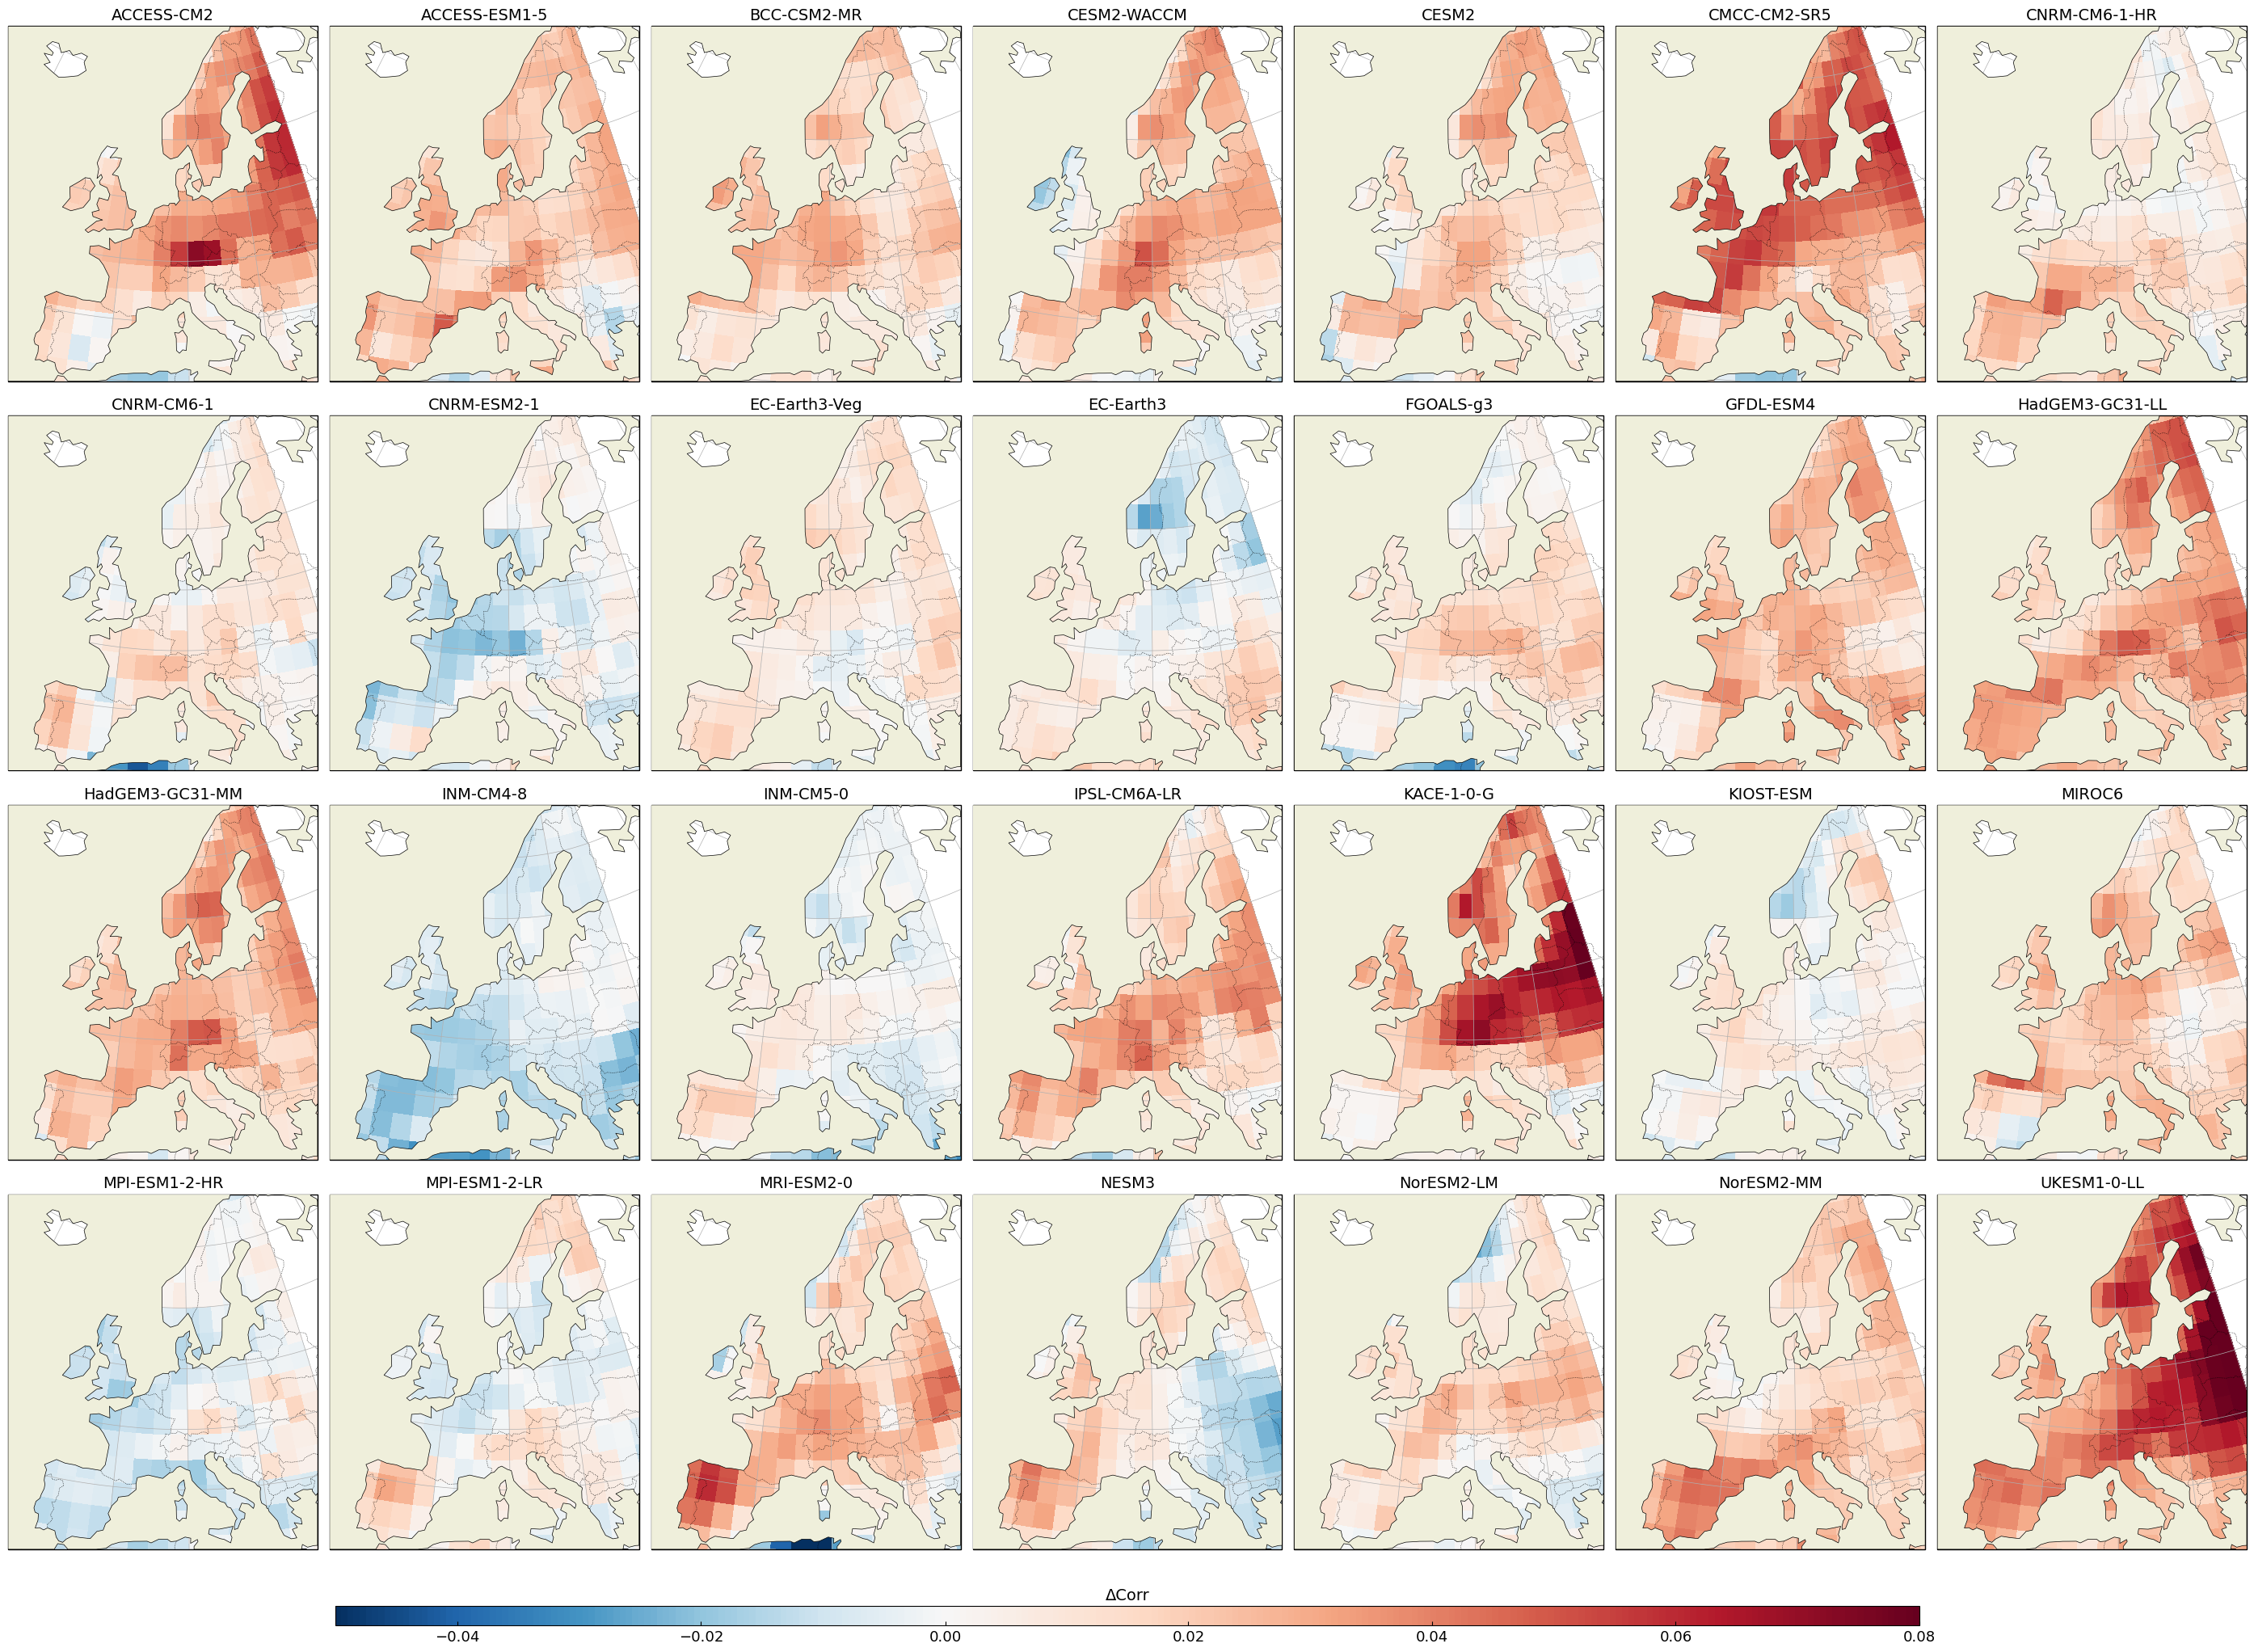

In [18]:
fig = plt.figure(figsize=(28,24)) 
for m in 1:28
    ax = plt.subplot(4,7, m, projection=proj3)
    ax.set_title(mdls[m], size=14)
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    
    wrap_data, wrap_lon = cput.add_cyclic_point(cor1dif[:,:,m]', coord=lon, axis=1)
    vmin, vmax = -0.05, 0.08
    norm = clrs.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    global md1 = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="RdBu_r", norm=norm)
end
plt.tight_layout()
fig.subplots_adjust(bottom=0.17)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.01])
fig.colorbar(md1, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_title("ΔCorr", size=14)
cbar_ax.tick_params(direction="in", labelsize=13)

### Ensemble members

In [21]:
function corrAllVari(s, pathPv)
    pathPv = joinpath(myPath, "pv", ssps[s], "day")
    rmcp(pathPv)
    corrAllGridAllVari = zeros(16,16,256,10)
    j = 1
    for i in 13:22 
        fnam = joinpath(pathPv, readdir(pathPv)[i])
        println(j, fnam)
        pv = ncread(fnam, "pv") 
        corrAllGridAllVari[:,:,:,j] = corrAllGrid(pv) 
        j += 1
    end
    return corrAllGridAllVari
end

corrAllVari (generic function with 1 method)

In [22]:
@time corHv = corrAllVari(1, pathPv)
cor1v = corrAllVari(2, pathPv)
cor5v = corrAllVari(5, pathPv);

1/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_20yr.nc
2/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_CNRM-ESM2-1_historical_r2i1p1f2_gr_20yr.nc
3/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_CNRM-ESM2-1_historical_r3i1p1f2_gr_20yr.nc
4/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_CNRM-ESM2-1_historical_r4i1p1f2_gr_20yr.nc
5/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_CNRM-ESM2-1_historical_r5i1p1f2_gr_20yr.nc
6/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_UKESM1-0-LL_historical_r1i1p1f2_gn_20yr.nc
7/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_UKESM1-0-LL_historical_r2i1p1f2_gn_20yr.nc
8/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_UKESM1-0-LL_historical_r3i1p1f2_gn_20yr.nc
9/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_UKESM1-0-LL_historical_r4i1p1f2_gn_20yr.nc
10/home/xinhou/radPV/pv/historical/day/reD_pvLat_eu_rsds_day_UKESM1-0-LL_

In [23]:
corHvMn, cor1vMn, cor5vMn = avg.([corHv, cor1v, cor5v]);

In [24]:
cor1vdif = corDif(cor1vMn, corHvMn, 1)
cor5vdif = corDif(cor5vMn, corHvMn, 1);

In [25]:
varisCN = ["ssp1 r1i1p1f2", "r2i1p1f2", "CNRM-ESM2-1\nr3i1p1f2", "r4i1p1f2", "r5i1p1f2",
           "ssp5 r1i1p1f2", "r2i1p1f2", "r3i1p1f2", "r4i1p1f2", "r5i1p1f2"];

varisUK = ["ssp1 r1i1p1f2", "r2i1p1f2", "UKESM1-0-LL\nr3i1p1f2", "r4i1p1f2", "r8i1p1f2",
           "ssp5 r1i1p1f2", "r2i1p1f2", "r3i1p1f2", "r4i1p1f2", "r8i1p1f2"];

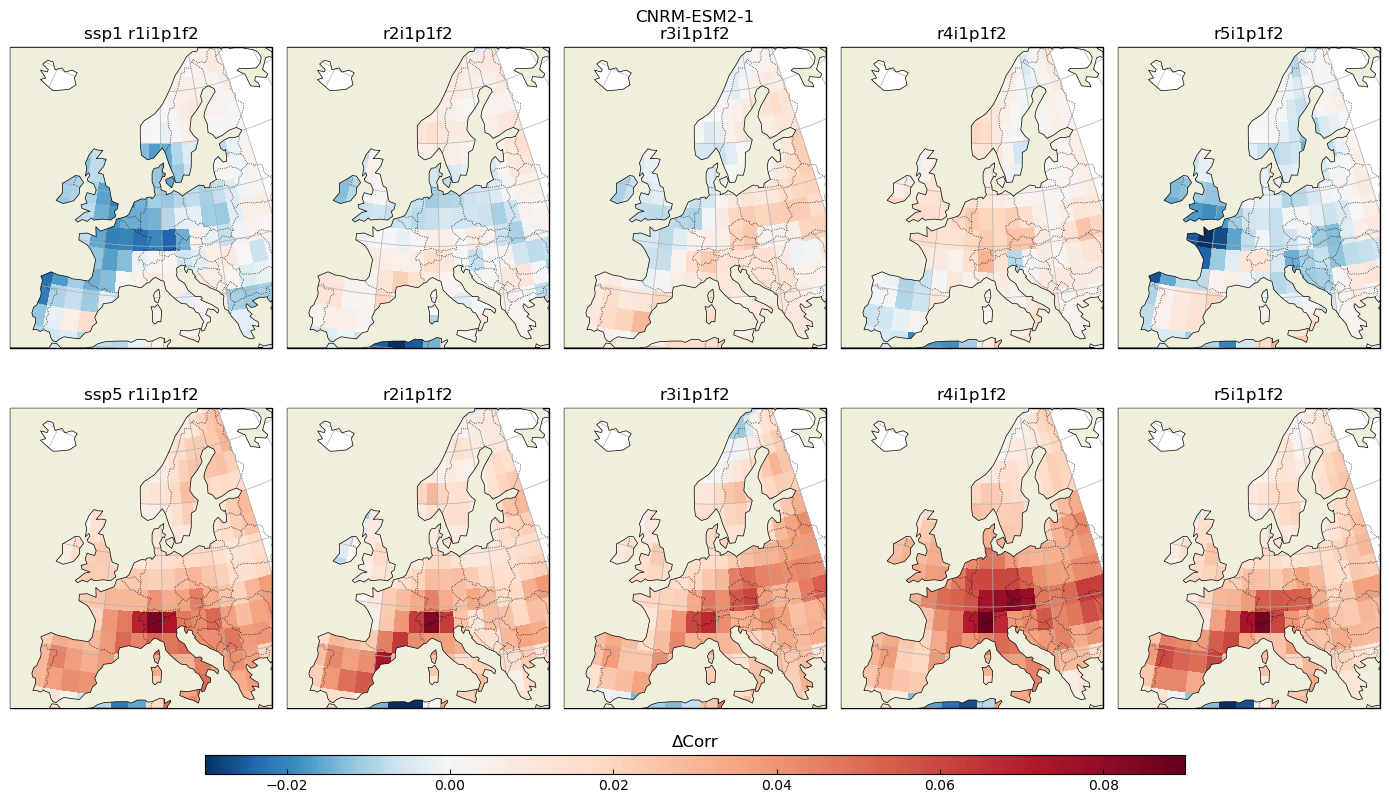

In [26]:
fig = plt.figure(figsize=(14,9.5))
for m in 1:10
    ax = plt.subplot(2,5, m, projection=proj3)
    ax.set_title(varisCN[m]) 
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":")
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    m <= 5 ?
        (arr = cor1vdif[:,:,m]') : (arr = cor5vdif[:,:,m-5]')
    wrap_data, wrap_lon = cput.add_cyclic_point(arr, coord=lon, axis=1)         
    vmin, vmax = -0.03, 0.09 
    norm = clrs.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    global variCN = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="RdBu_r", norm=norm)
end
plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.02])
fig.colorbar(variCN, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_title("ΔCorr") 
cbar_ax.tick_params(direction="in") 

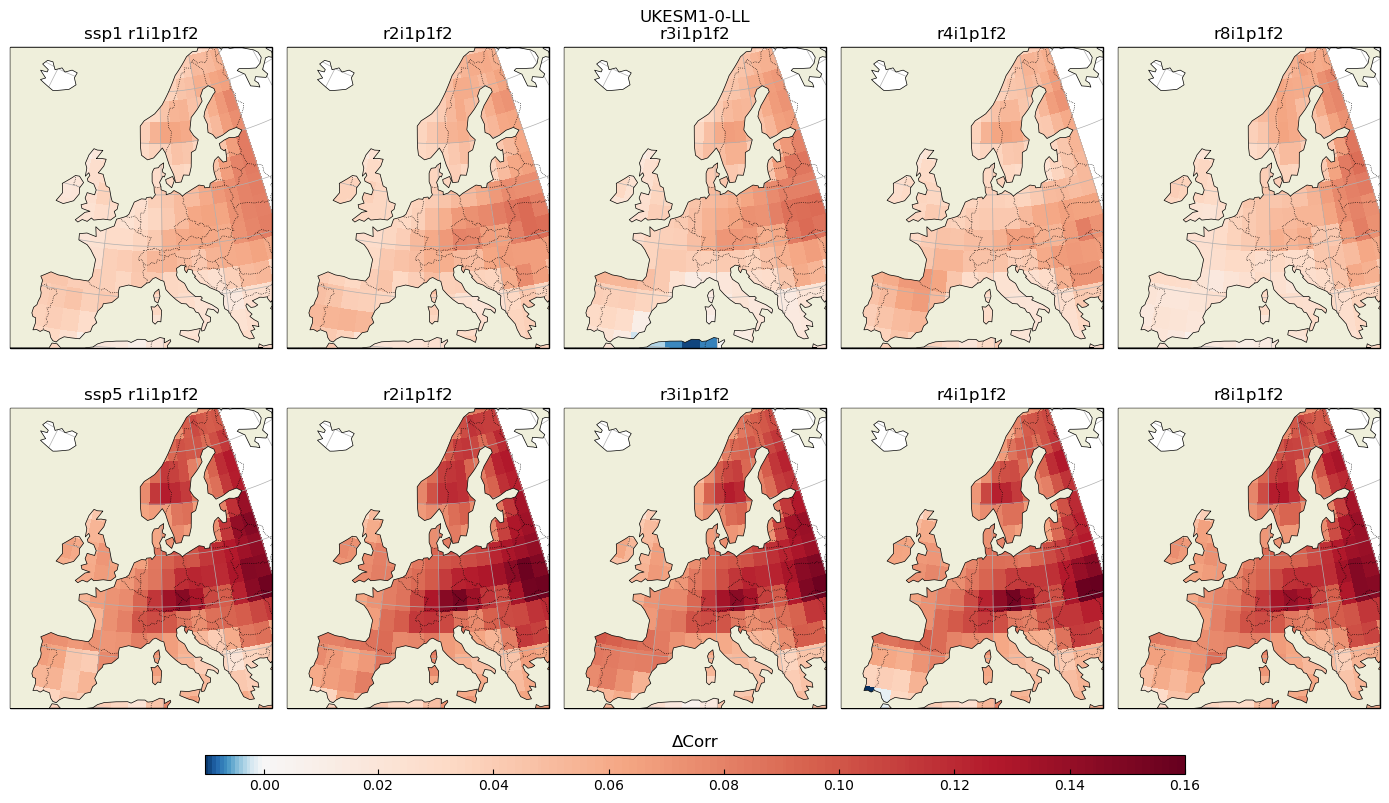

In [28]:
fig = plt.figure(figsize=(14,9.5))
for m in 1:10
    ax = plt.subplot(2,5, m, projection=proj3)
    ax.set_title(varisUK[m]) 
    ax.gridlines(linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":")
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
    m <= 5 ?
        (arr = cor1vdif[:,:,m+5]') : (arr = cor5vdif[:,:,m]')
    wrap_data, wrap_lon = cput.add_cyclic_point(arr, coord=lon, axis=1)         
    vmin, vmax = -0.01, 0.16 
    norm = clrs.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
    global variUK = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="RdBu_r", norm=norm)
end
plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.02])
fig.colorbar(variUK, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_title("ΔCorr") 
cbar_ax.tick_params(direction="in") 